In [4]:
import numpy as np
import pandas as pd
import anndata as ad
from anndata import AnnData
import scanpy as sc

import matplotlib.pyplot as plt

import gc
import glob
import sys

from tqdm import tqdm

import torch 
torch.set_float32_matmul_precision("high")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

torch.cuda.is_available()

True

In [5]:
def cleanup():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def flatten_list(xss):
    return [x for xs in xss for x in xs]

Load the MERFISH tangram imputation

In [3]:
adata = sc.read_h5ad("data/tangram/merfish.tangram_imputed.5k_mini.h5ad")
del adata.layers['scaled']
filt = (adata.obs['tissue_compartment'] != 'outside tissue') & (~adata.obs['cell_type.detailed'].isin(['Unknown', 'Doublet']))
adata = adata[filt].copy()
cleanup()

Load the ligand-receptor database from CellChatDB.

In [11]:
lrdb = pd.read_csv("/sc/arion/projects/ji_lab/USER/restrp01/ns-atlas/data/cellchat/CellChatDB_interaction_table.csv", index_col=0)
lrdb['ligand'] = lrdb['ligand.symbol'].apply(lambda x: x.replace(", ", "+"))
lrdb['receptor'] = lrdb['receptor.symbol'].apply(lambda x: x.replace(", ", "+"))
lrdb['interaction_name'] = lrdb['ligand'] + "_" + lrdb['receptor']
lrdb = lrdb[['interaction_name', 'ligand', 'receptor','pathway_name', 'annotation']].drop_duplicates()
lrdb.index = lrdb['interaction_name'].values.copy()

# filter the LRs for those where all constituent genes in the interaction are present in the adata object.
lr_list = lrdb['interaction_name'].apply(lambda x: x.replace("+", "_").split("_"))
lr_filt = lr_list.apply(lambda x: sum([i in adata.var_names for i in x])/len(x) == 1)
lrdb = lrdb[lr_filt]

# prepare variables for the ligands, receptors, their genes, and tuples to have on-hand.
ligand_ids =  lrdb['ligand'].tolist()
receptor_ids = lrdb['receptor'].tolist()

ligands = lrdb["ligand"].apply(lambda x: x.split("+")).tolist()
receptors = lrdb["receptor"].apply(lambda x: x.split("+")).tolist()
lr_pairs = [(ligands[i], receptors[i]) for i in range(0, len(ligands))]

receptor_genes = np.unique(flatten_list(receptors))
ligand_genes = np.unique(flatten_list(ligands))
lr_genes = np.unique(np.concatenate([ligand_genes, receptor_genes]))
cleanup()

In [12]:
lrdb.head()

interaction_name ligand       receptor pathway_name  \
TGFB1_TGFBR2+TGFBR1  TGFB1_TGFBR2+TGFBR1  TGFB1  TGFBR2+TGFBR1         TGFb   
TGFB2_TGFBR2+TGFBR1  TGFB2_TGFBR2+TGFBR1  TGFB2  TGFBR2+TGFBR1         TGFb   
TGFB3_TGFBR2+TGFBR1  TGFB3_TGFBR2+TGFBR1  TGFB3  TGFBR2+TGFBR1         TGFb   
TGFB1_TGFBR2+ACVR1B  TGFB1_TGFBR2+ACVR1B  TGFB1  TGFBR2+ACVR1B         TGFb   
TGFB1_TGFBR2+ACVR1C  TGFB1_TGFBR2+ACVR1C  TGFB1  TGFBR2+ACVR1C         TGFb   

                             annotation  
TGFB1_TGFBR2+TGFBR1  Secreted Signaling  
TGFB2_TGFBR2+TGFBR1  Secreted Signaling  
TGFB3_TGFBR2+TGFBR1  Secreted Signaling  
TGFB1_TGFBR2+ACVR1B  Secreted Signaling  
TGFB1_TGFBR2+ACVR1C  Secreted Signaling

pre-filter the matrix for only the LR genes to free memory

In [13]:
adata = adata[:, lr_genes].copy()
cleanup()

In [14]:
adata_size_gb = np.round(sys.getsizeof(adata) * 1e-9, decimals=2)
print(f"The adata object is {adata_size_gb} GB")

The adata object is 20.27 GB


In [15]:
def get_neighbors(
    adata: ad.AnnData,
    sample_key: str,
    spatial_key: str,
    n_neighbors: int = 5,
    distance_cutoff = 200,
    device: str = "cuda"
):
    coords = torch.tensor(adata.obsm[spatial_key], device=device, dtype=torch.float32)

    sample_names = adata.obs[sample_key].unique()
    sample_masks = {s: (adata.obs[sample_key] == s).values for s in sample_names}
    neighbor_records = []

    for sample in tqdm(sample_names, desc="[Finding neighbors]", leave=False):
        mask = sample_masks[sample]
        coords_sample = coords[mask]
        local_indices = torch.where(torch.tensor(mask, device=device))[0]

        dists = torch.cdist(coords_sample, coords_sample)
        neighbors_sample = torch.zeros_like(dists, dtype=torch.bool)
        topk = dists.topk(n_neighbors, largest=False)
        neighbors_sample.scatter_(1, topk.indices, True)

        if distance_cutoff is not None:
            filt = dists <= distance_cutoff
            neighbors_sample = neighbors_sample & filt

        for i in range(neighbors_sample.shape[0]):
            global_i = local_indices[i].item()
            local_neighbors = torch.where(neighbors_sample[i])[0]
            local_distances = dists[i, local_neighbors].cpu().numpy()

            if len(local_neighbors) > 0:
                ranks = np.argsort(np.argsort(local_distances)) + 1  # rank 1 = closest

            for j, dist, rank in zip(local_neighbors, local_distances, ranks):
                global_j = local_indices[j].item()
                neighbor_records.append({
                    "sample_id": sample,
                    "centroid_cell": adata.obs_names[global_i],
                    "neighbor_cell": adata.obs_names[global_j],
                    "distance": dist,
                    "rank": rank
                })

    neighbor_df = pd.DataFrame(neighbor_records)
    cleanup()

    return neighbor_df

In [16]:
neighbordf = get_neighbors(adata, n_neighbors=10, sample_key='sample_barcode', spatial_key='spatial', distance_cutoff=None)
neighbordf.to_csv("data/metadata/ns-atlas.merfish.k10.knn_neighbor_df.csv.gz")
cleanup()

In [17]:
neighbordf = pd.read_csv("data/metadata/ns-atlas.merfish.k10.knn_neighbor_df.csv.gz", index_col=0, dtype={'centroid_cell': object, 'neighbor_cell': object})
# filter the neighbordf for those within the 200 um
filt = (neighbordf['distance'] <= 200) & (neighbordf['rank'] <= 5)
neighbordf = neighbordf[filt].sort_values(["centroid_cell", "rank"]) # Ensure correct order by rank

In [18]:
neighbordf.head()

sample_id        centroid_cell        neighbor_cell   distance  \
0  D151_SKIN_NS_S04_R01  1577244300000000000  1577244300000000000   0.000000   
4  D151_SKIN_NS_S04_R01  1577244300000000000  1577244300000005752   6.928203   
9  D151_SKIN_NS_S04_R01  1577244300000000000  1577244300000009449   6.928203   
6  D151_SKIN_NS_S04_R01  1577244300000000000  1577244300000008601  13.266500   
5  D151_SKIN_NS_S04_R01  1577244300000000000  1577244300000005992  13.856406   

   rank  
0     1  
4     2  
9     3  
6     4  
5     5

In [19]:
grouped = (
    neighbordf
    .sort_values(["centroid_cell", "rank"])  # Ensure correct order by rank
    .groupby("centroid_cell")["neighbor_cell"]
    .apply(list)
)
centroid_cells = np.unique(np.intersect1d(adata.obs_names.values, grouped.index.values))
neighbor_list = [grouped[centroid] for centroid in centroid_cells]

In [20]:
centroid_to_neighbors = (
    neighbordf
    .groupby("centroid_cell")["neighbor_cell"]
    .apply(list)
    .to_dict()
)

neighbor_list = []
for centroid in centroid_cells:
    neighbors = centroid_to_neighbors.get(centroid, [])
    neighbor_indices = np.array([adata.obs_names.get_loc(nbr) for nbr in neighbors], dtype=int)
    neighbor_list.append(neighbor_indices)

In [21]:
def aggregate_subunits(adata, layer, subunit_list, subunit_sep='+', device='cuda'):
    from collections import defaultdict
    import pandas as pd
    obs_names = adata.obs_names.copy()
    var_names = adata.var_names.copy()
    gene_index = {gene: i for i, gene in enumerate(var_names)}
    
    X = adata.layers[layer]
    if not isinstance(X, np.ndarray):
        X = X.toarray()
    
    subunit_dict = dict(zip(subunit_list, [x.split(subunit_sep) for x in subunit_list]))

    expr_dict = {}
    
    for key, value in subunit_dict.items():
        idx = [gene_index[g] for g in value]
        expr = torch.tensor(X[:, idx], device=device, dtype=torch.float32).min(dim=1).values
        expr_dict[key] = expr.cpu().numpy()
    
    cleanup()

    return expr_dict

To aggregate across heteromeric subunits, use the minimum expression of the subunits.

In [22]:
expr_dict = aggregate_subunits(adata, layer='tangram', subunit_list=np.unique(np.concatenate([ligand_ids, receptor_ids])))
expr_mat = pd.DataFrame(expr_dict, index=adata.obs_names)
cleanup()

In [23]:
expr_mat.to_csv("data/tangram/lr_subunit_expression_matrix.csv")

In [24]:
expr_mat = pd.read_csv("data/tangram/lr_subunit_expression_matrix.csv", index_col=0)
expr_mat.index = expr_mat.index.astype('str')

/tmp/ipykernel_1331585/543522089.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  expr_mat = pd.read_csv("data/tangram/lr_subunit_expression_matrix.csv", index_col=0)


In [25]:
import torch
from scipy.stats import rankdata

def score_additive(lig_neigh, rec_neigh, **kwargs):
    """Returns the average of ligand and receptor expression."""
    return 0.5 * (lig_neigh + rec_neigh)

def score_geometric(lig_neigh, rec_neigh, **kwargs):
    """Returns the geometric mean of ligand and receptor expression with a pseudocount."""
    lig_c = torch.clamp(lig_neigh, min=0)
    rec_c = torch.clamp(rec_neigh, min=0)
    return torch.sqrt(lig_c * rec_c)

SCORING_FUNCTIONS = {
    "additive": score_additive,
    "geometric": score_geometric
}


In [26]:
def score_knn_lrs(
    expr,
    lrdb,
    obs_names,
    neighbor_list,
    ligand_key: str = 'ligand',
    receptor_key: str = 'receptor',
    interaction_key: str = 'interaction_name',
    mode: str = 'additive',
    device: str = 'cuda'
):

    expr = {key: torch.tensor(value, device=device) for key, value in expr.items()}

    
    # Pad neighbor list
    max_k = max(len(nbrs) for nbrs in neighbor_list)
    padded_neighbors = torch.full((len(neighbor_list), max_k), fill_value=-1, dtype=torch.long, device=device)
    for i, nbrs in enumerate(neighbor_list):
        padded_neighbors[i, :len(nbrs)] = torch.tensor(nbrs, device=device)

    # Create mask (True = valid index)
    neighbor_mask = padded_neighbors != -1

    lr_scores = {}
    with tqdm(total=len(lrdb), desc="Scoring LR pairs", unit="LR", ncols=100, leave=True) as pbar:
        for index, row in lrdb.iterrows():
            interaction_name = row[interaction_key]
            ligand = row[ligand_key]
            receptor = row[receptor_key]

            lig_expr = expr[ligand]  # shape: [C]
            rec_expr = expr[receptor]  # shape: [C]
            
            # Assume expr is a torch.Tensor with shape [G, C]
            # Lookup expressions using padded neighbors
            lig_expr = lig_expr[padded_neighbors]  # shape: [n_cells, max_k]
            rec_expr = rec_expr[padded_neighbors]

            # Mask invalid entries
            lig_expr[~neighbor_mask] = float('nan')
            rec_expr[~neighbor_mask] = float('nan')

            lig_neigh = lig_expr.nanmean(dim=1)
            rec_neigh = rec_expr.nanmean(dim=1)
            
            score_fn = SCORING_FUNCTIONS[mode]
            scores = score_fn(lig_neigh, rec_neigh)
            if not isinstance(scores, torch.Tensor):
                scores = torch.tensor(scores, device=expr.device)

            lr_scores[interaction_name] = scores.cpu().numpy()

            pbar.update(1)
    
    cleanup()
    
    score_mat = pd.DataFrame(lr_scores, index = obs_names)
    return(score_mat)

In [29]:
gmean_scores = score_knn_lrs(
    expr = expr_dict, lrdb = lrdb, obs_names = centroid_cells, neighbor_list=neighbor_list,
    ligand_key='ligand', receptor_key='receptor', interaction_key='interaction_name', mode='geometric'
)

Scoring LR pairs: 100%|████████████████████████████████████████| 1854/1854 [00:02<00:00, 774.03LR/s]


In [30]:
additive_scores = score_knn_lrs(
    expr = expr_dict, lrdb = lrdb, obs_names = centroid_cells, neighbor_list=neighbor_list,
    ligand_key='ligand', receptor_key='receptor', interaction_key='interaction_name', mode='additive'
)

Scoring LR pairs: 100%|████████████████████████████████████████| 1854/1854 [00:02<00:00, 821.39LR/s]


In [31]:
cleanup()

In [32]:
obs = adata.obs.loc[centroid_cells, :]

In [35]:
obs.head()

EntityID  fov       volume      center_x  \
1577244300000000000  1577244300000000000  NaN   413.582367  10833.988067   
1577244300000000002  1577244300000000002  NaN  2314.160266   9533.604246   
1577244300000000003  1577244300000000003  NaN  1377.588139  10330.515975   
1577244300000000006  1577244300000000006  NaN   364.332251  11125.854334   
1577244300000000008  1577244300000000008  NaN  1137.968435  10640.326353   

                        center_y         min_x        min_y         max_x  \
1577244300000000000  5659.833278  10830.405562  5656.014926  10838.326891   
1577244300000000002  6785.310602   9526.056136  6778.549632   9543.619093   
1577244300000000003  5700.319847  10320.137869  5693.969074  10343.894569   
1577244300000000006  6012.214286  11122.113357  6009.566081  11131.581724   
1577244300000000008  7268.846994  10634.916613  7262.627689  10647.572479   

                           max_y  anisotropy  ...  preservation_type  \
1577244300000000000  5662.925291    1.535899  ...               FFPE   
1577244300000000002  6794.195938    1.315076  ...               FFPE   
1577244300000000003  5705.211938    3.583034  ...               FFPE   
1577244300000000006  6014.614107    1.857338  ...               FFPE   
1577244300000000008  7274.467481    1.099862  ...               FFPE   

                     collection_type                   component_id  \
1577244300000000000          autopsy     D151_SKIN_NS_S04_R01_N6_C0   
1577244300000000002          autopsy   D151_SKIN_NS_S04_R01_N0_C619   
1577244300000000003          autopsy   D151_SKIN_NS_S04_R01_N1_Cnan   
1577244300000000006          autopsy     D151_SKIN_NS_S04_R01_N6_C0   
1577244300000000008          autopsy  D151_SKIN_NS_S04_R01_N2_C2046   

                           sample_compartment  tissue_compartment  \
1577244300000000000  D151_SKIN_NS_S04_R01_DER              dermis   
1577244300000000002  D151_SKIN_NS_S04_R01_DER              dermis   
1577244300000000003  D151_SKIN_NS_S04_R01_DER              dermis   
1577244300000000006  D151_SKIN_NS_S04_R01_DER              dermis   
1577244300000000008  D151_SKIN_NS_S04_R01_EPI           epidermis   

                     compartment.short        sample_barcode  uniform_density  \
1577244300000000000                DER  D151_SKIN_NS_S04_R01         0.000012   
1577244300000000002                DER  D151_SKIN_NS_S04_R01         0.000012   
1577244300000000003                DER  D151_SKIN_NS_S04_R01         0.000012   
1577244300000000006                DER  D151_SKIN_NS_S04_R01         0.000012   
1577244300000000008                EPI  D151_SKIN_NS_S04_R01         0.000012   

                     rna_count_based_density  dataset  
1577244300000000000                 0.000012        0  
1577244300000000002                 0.000012        0  
1577244300000000003                 0.000012        0  
1577244300000000006                 0.000012        0  
1577244300000000008                 0.000012        0  

[5 rows x 111 columns]

In [36]:
lr_adata = ad.AnnData(X=gmean_scores, obs=obs, var=lrdb)
lr_adata.layers['additive'] = additive_scores.copy()
lr_adata.layers['gmean'] = gmean_scores.copy()
lr_adata.obsm['spatial'] = adata[obs.index].obsm['spatial'].copy()

In [37]:
from scipy.stats import zscore
lr_adata.layers['additive_zscore'] = zscore(lr_adata.layers['additive'], axis=0, nan_policy="omit").copy()
lr_adata.layers['gmean_zscore'] = zscore(lr_adata.layers['gmean'], axis=0, nan_policy="omit").copy()

In [38]:
lr_adata.write_h5ad("data/tangram/merfish.tangram_projected.lr_scores.full.anndata_object.h5ad")

In [ ]:
lr_adata = sc.read_h5ad("data/tangram/merfish.tangram_projected.lr_scores.full.anndata_object.h5ad")

In [39]:
test_sample = "D165_SKIN_NS_S03_R01"
test_obj = lr_adata[lr_adata.obs['sample_barcode'] == test_sample]

In [40]:
cleanup()

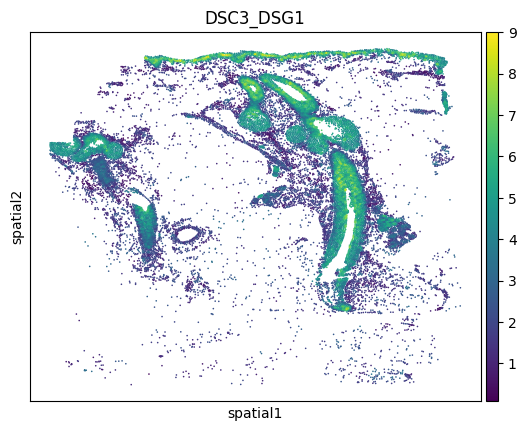

In [41]:
sc.pl.embedding(test_obj, basis='spatial',layer='gmean', color='DSC3_DSG1')

In [18]:
test_obj.obs["DSC3_DSG1.PERIVASC_I"] = test_obj.to_df()["DSC3_DSG1"].copy()
test_obj.obs.loc[test_obj.obs['neighborhood'] != "PERIVASC-I", "DSC3_DSG1.PERIVASC_I"] = np.nan

In [28]:
detailed_celltypes = ['Retic Fib I', 'Mast', 'HEC', 'Mac', 'Peri', 'CD4+ Th', 'Naïve T', 'DP',
                      'CD1C+ DC', 'Perivasc Fib II', 'DS', 'VEC', 'Perivasc Fib I', 'CD8+ Tc', 'Papil Fib', 
                      'CLEC9A+ DC', 'Schwann', 'CD4+ Treg', 'Retic Fib III']

In [29]:
nhood_adata = lr_adata[lr_adata.obs['neighborhood'] == 'PERIVASC-I']
nhood_adata = nhood_adata[[x in detailed_celltypes for x in nhood_adata.obs['cell_type.detailed']]]

In [32]:
nhood_adata.obs['anatomic_site']

1577244300000000003    back
1577244300000000055    back
1577244300000000081    back
1577244300000000129    back
1577244300000000173    back
                       ... 
1586529100000135382    face
1586529100000135394    face
1586529100000135396    face
1586529100000135398    face
1586529100000135399    face
Name: anatomic_site, Length: 102772, dtype: category
Categories (15, object): ['abdomen', 'antecubital fossa', 'back', 'buttocks', ..., 'occipital scalp', 'popliteal fossae', 'postauricular', 'sole']

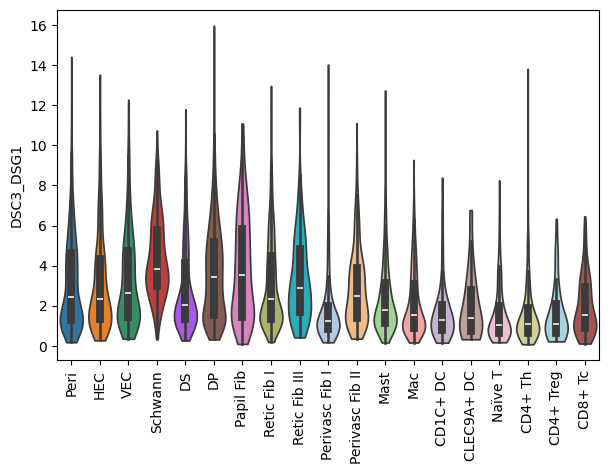

In [35]:
sc.pl.violin(nhood_adata[nhood_adata.obs['anatomic_site'] == 'occipital scalp'], 
             ["DSC3_DSG1"],
             groupby="cell_type.detailed",
             rotation=90,
             stripplot=False,  # remove the internal dots
             inner="box")

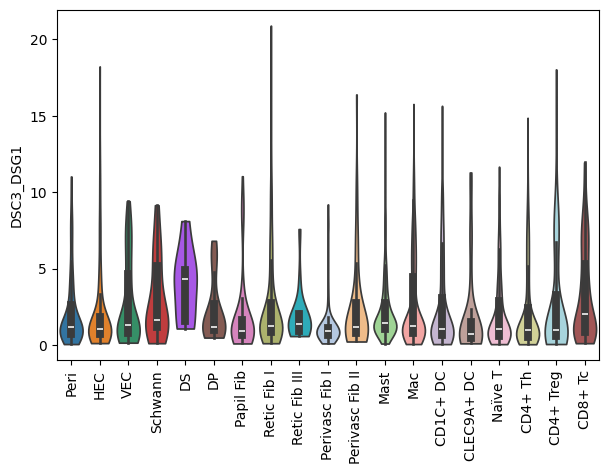

In [36]:
sc.pl.violin(nhood_adata[nhood_adata.obs['anatomic_site'] == 'antecubital fossa'], 
             ["DSC3_DSG1"],
             groupby="cell_type.detailed",
             rotation=90,
             stripplot=False,  # remove the internal dots
             inner="box")

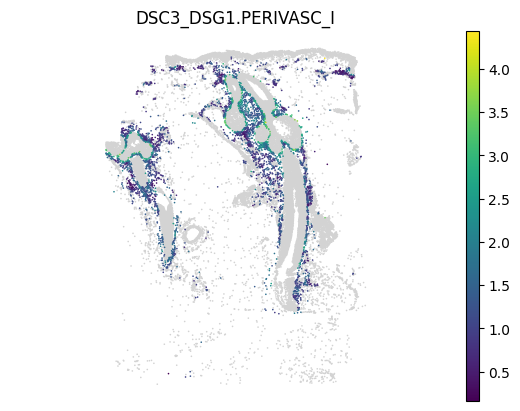

In [23]:
fig, axes = plt.subplots()
axes.set_aspect('equal', adjustable='datalim')
axes.set_xticks([])
axes.set_yticks([])
sc.pl.embedding(test_obj, basis='spatial', color="DSC3_DSG1.PERIVASC_I", ax=axes, frameon=False)

In [ ]:
fig, axes = plt.subplots()
axes.set_aspect('equal', adjustable='datalim')
axes.set_xticks([])
axes.set_yticks([])
sc.pl.embedding(test_obj, basis='spatial',layer='gmean', color='CXCL12_CXCR4', ax=axes)

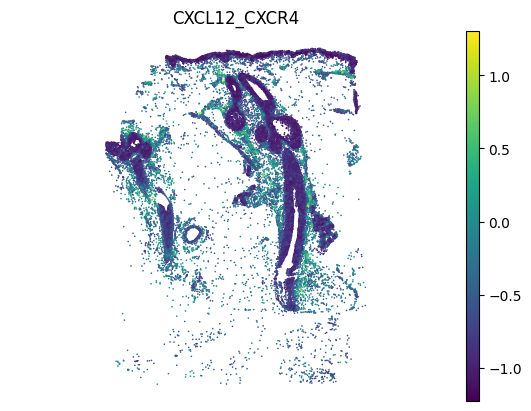

In [42]:
fig, axes = plt.subplots()
axes.set_aspect('equal', adjustable='datalim')
axes.set_xticks([])
axes.set_yticks([])
sc.pl.embedding(test_obj, basis='spatial',layer='gmean_zscore', color='CXCL12_CXCR4', ax=axes, frameon=False)

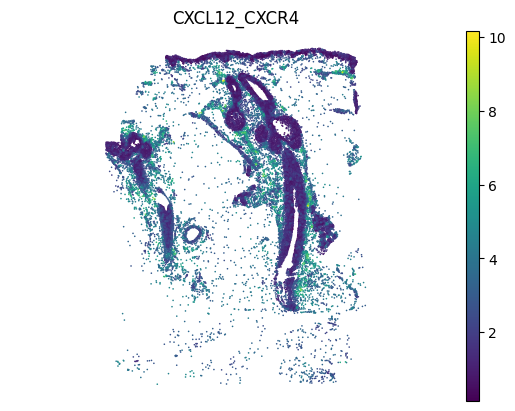

In [43]:
fig, axes = plt.subplots()
axes.set_aspect('equal', adjustable='datalim')
axes.set_xticks([])
axes.set_yticks([])
sc.pl.embedding(test_obj, basis='spatial',layer='gmean', color='CXCL12_CXCR4', ax=axes, frameon=False)

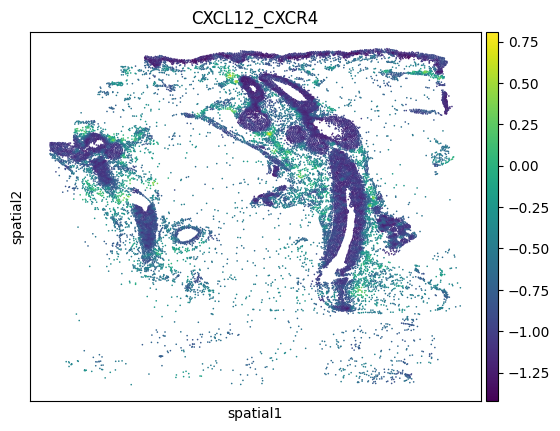

In [180]:
sc.pl.embedding(test_obj, basis='spatial',layer='additive_zscore', color='CXCL12_CXCR4')

Filter for cell types with most abundance before aggregating, and do the geometric mean on a cell-to-cell basis

In [44]:
import torch
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import itertools
import decoupler as dc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
neighborhood_composition_dict = {
    "DEJ": ["Papil Fib","Bas KC","Melano"],
    "PERIVASC-I": ["CCR7+ DC","CD4+ Treg","Naïve T","CD8+ Tc","CD4+ Th","Mast","CD1C+ DC","CLEC9A+ DC",
                   "Perivasc Fib I","Perivasc Fib II", "VEC","Peri","HEC","Plasma","Cyc Imm","Mac","Mono"],
    "DIFF-IFE": ["Grn KC","Spn KC I","Bas KC","Cyc KC","LC","Spn KC II"],
    "PERIVASC-II": ["SM","LEC","Schwann","Retic Fib III","Peri","VEC","HEC","Perivasc Fib I","Perivasc Fib II"],
    "STROMA": ["Retic Fib II","Retic Fib I","Mac"],
    "UPPER-HF": ["Melano","Bas KC","Cyc KC","LC","Spn KC II","Bas Inf","Diff Inf"],
    "ECCRINE": ["Ecc Myoepi","Ecc Duct","Ecc Gland"],
    "SEB-GLND": ["Bas Seb","Diff Seb"],
    "SUBCUTIS": ["Adipo","Mono","Perivasc Fib I","Perivasc Fib II"],
    "LOWER-HF": ["Bulge","ORS Basal","ORS Suprabasal","IRS/HS","Melano","DP","DS"]
}

In [11]:
neighborhoods = ['DEJ', 'PERIVASC-I', 'DIFF-IFE', 'PERIVASC-II', 'STROMA', 'UPPER-HF', 'ECCRINE', 'SEB-GLND', 'SUBCUTIS', 'LOWER-HF']

In [12]:
pb_adata = ad.AnnData(expr_mat, obs = adata.obs.loc[expr_mat.index.values].copy())
pb_adata.obs['neighborhood_celltype'] = pb_adata.obs['neighborhood'].astype(str) + ": " + pb_adata.obs['cell_type.detailed'].astype(str)

In [17]:
cleanup()

In [18]:
result_list = []
for nhood in neighborhoods:
    print(nhood)
    nhood_adata = pb_adata[pb_adata.obs['neighborhood'] == nhood].copy()
    nhood_adata = dc.pp.pseudobulk(nhood_adata, sample_col="sample_barcode", groups_col="cell_type.detailed", mode='sum', skip_checks = True, verbose=True)
    nhood_adata.write_h5ad(f"data/cellchat/{nhood}.tangram_lr_expr.neighborhood_celltype_sample.pseudobulk.sum.h5ad")

    detailed_celltypes = list(np.unique(nhood_adata.obs['cell_type.detailed'].astype('str').values))
    print(detailed_celltypes)

    cleanup()
    
    celltype_pairs = [pair for pair in itertools.product(detailed_celltypes, repeat=2)]
    
    # Assume nhood_adata.X is already pseudobulked: rows = sample-celltype, columns = genes
    # And nhood_adata.obs has 'sample_barcode' and 'cell_type.detailed'
    # Genes in nhood_adata.var_names
    
    # Precompute mapping from gene name to index
    gene_names = list(nhood_adata.var_names)
    gene_to_idx = {g: i for i, g in enumerate(gene_names)}
    
    # Convert entire expression matrix to torch tensor on GPU
    expr_matrix = torch.tensor(nhood_adata.X, dtype=torch.float32, device=device)
    obs_df = nhood_adata.obs
    
    # Extract unique samples for final output index
    sample_barcodes = obs_df['sample_barcode'].values
    nhood_result_list = []
    with tqdm(total=len(celltype_pairs), desc="Scoring LR pairs", unit="LR", ncols=100, leave=True) as pbar:
        for sender, receiver in celltype_pairs:
            pair = f"{sender} -> {receiver}"
        
            # Indices of rows corresponding to sender and receiver pseudobulked celltypes
            sender_mask = (obs_df['cell_type.detailed'].values == sender)
            receiver_mask = (obs_df['cell_type.detailed'].values == receiver)
        
            sender_expr = expr_matrix[sender_mask]  # shape [n_samples, n_genes]
            receiver_expr = expr_matrix[receiver_mask]  # shape [n_samples, n_genes]
        
            assert sender_expr.shape[0] == receiver_expr.shape[0], "Mismatch in sample count"
        
            # Output structure
            lr_scores = {
                'neighborhood': [nhood] * sender_expr.shape[0],
                'sample_barcode': sample_barcodes[sender_mask],
                'pair': [pair] * sender_expr.shape[0],
                'sender': [sender] * sender_expr.shape[0],
                'receiver': [receiver] * sender_expr.shape[0]
            }
        
            # Batch all interactions at once: build index vectors
            lig_idx = torch.tensor([gene_to_idx[lig] for lig in lrdb['ligand']], device=device)
            rec_idx = torch.tensor([gene_to_idx[rec] for rec in lrdb['receptor']], device=device)
        
            # Extract expression for all ligands and receptors
            lig_expr = sender_expr[:, lig_idx]  # shape: [n_samples, n_lr_pairs]
            rec_expr = receiver_expr[:, rec_idx]  # shape: [n_samples, n_lr_pairs]
        
            # Compute LR scores: sqrt(L * R)
            scores = torch.sqrt(lig_expr * rec_expr)  # shape: [n_samples, n_lr_pairs]
        
            # Add each LR score column to result
            for i, interaction_name in enumerate(lrdb['interaction_name']):
                lr_scores[interaction_name] = scores[:, i].cpu().numpy()
        
            result_list.append(pd.DataFrame(lr_scores))
            nhood_result_list.append(pd.DataFrame(lr_scores))
            
            pbar.update(1)
    nhood_resultdf = pd.concat(nhood_result_list)
    nhood_resultdf.to_csv(f"data/cellchat/{nhood}.tangram_lrscores.cellpairs.gmean.sum.csv")
resultdf = pd.concat(result_list)

DEJ


2025-07-24 12:47:54 | [INFO] Extracted omics mat with 86158 rows (observations) and 945 columns (features)
2025-07-24 12:47:56 | [INFO] Generating 5130 profiles: 114 samples x 45 groups
2025-07-24 12:47:56 | [INFO] Using function sum to aggregate observations
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=2	counts=864.0889391481708
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=0	counts=0.0
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=0	counts=0.0
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=2	counts=1862.9436891444711
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=3	counts=4270.93290585437
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=5	counts=7705.269958672867
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=4	counts=5371.765574949457
2025-07-24 12:47:56 | [INFO] group=Adipo	sample=D028_S

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 2025/2025 [02:59<00:00, 11.31LR/s]


PERIVASC-I


2025-07-24 12:55:40 | [INFO] Extracted omics mat with 110787 rows (observations) and 945 columns (features)
2025-07-24 12:55:42 | [INFO] Generating 5130 profiles: 114 samples x 45 groups
2025-07-24 12:55:42 | [INFO] Using function sum to aggregate observations
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=102	counts=52471.894604451634
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=131	counts=94359.44679483277
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=10	counts=15146.573665438818
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=10	counts=10420.958298834292
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=3	counts=4037.3227913068295
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=9	counts=14349.006715860463
2025-07-24 12:55:42 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=0	counts=0.0
2025-07-24 12:55:42 | [INFO]

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 2025/2025 [02:58<00:00, 11.33LR/s]


DIFF-IFE


2025-07-24 13:02:41 | [INFO] Extracted omics mat with 147547 rows (observations) and 945 columns (features)
2025-07-24 13:02:43 | [INFO] Generating 4218 profiles: 114 samples x 37 groups
2025-07-24 13:02:43 | [INFO] Using function sum to aggregate observations
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S04_R02	cells=0	counts=0.0
2025-07-24 13:02:43 | [INFO] group=

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD4+ Th', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mast', 'Melano', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 1369/1369 [02:01<00:00, 11.24LR/s]


PERIVASC-II


2025-07-24 13:07:20 | [INFO] Extracted omics mat with 143034 rows (observations) and 945 columns (features)
2025-07-24 13:07:23 | [INFO] Generating 5130 profiles: 114 samples x 45 groups
2025-07-24 13:07:23 | [INFO] Using function sum to aggregate observations
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=23	counts=11215.341455934362
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=6	counts=3762.429951099586
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=2	counts=2702.7439952789346
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=3	counts=4846.167705094871
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=12	counts=19514.889998654042
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=1	counts=1261.075928179172
2025-07-24 13:07:23 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=18	counts=28046.929810794663
2025-07-24 13:07:2

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 2025/2025 [02:59<00:00, 11.28LR/s]


STROMA


2025-07-24 13:14:05 | [INFO] Extracted omics mat with 126513 rows (observations) and 945 columns (features)
2025-07-24 13:14:07 | [INFO] Generating 5016 profiles: 114 samples x 44 groups
2025-07-24 13:14:07 | [INFO] Using function sum to aggregate observations
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=2	counts=1049.7286133042708
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=1	counts=744.9326771168539
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=38	counts=53125.866738098935
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=115	counts=114567.21053373543
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=5	counts=6684.842766138721
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=5	counts=7799.20868453495
2025-07-24 13:14:07 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=13	counts=19776.14493404553
2025-07-24 13:14:07

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 1936/1936 [02:51<00:00, 11.27LR/s]


UPPER-HF


2025-07-24 13:20:26 | [INFO] Extracted omics mat with 98672 rows (observations) and 945 columns (features)
2025-07-24 13:20:28 | [INFO] Generating 4770 profiles: 106 samples x 45 groups
2025-07-24 13:20:28 | [INFO] Using function sum to aggregate observations
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=1	counts=503.76267091314304
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=2	counts=1401.59722254195
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=0	counts=0.0
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=0	counts=0.0
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=0	counts=0.0
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=0	counts=0.0
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=0	counts=0.0
2025-07-24 13:20:28 | [INFO] group=Adipo	sample=D028_SKIN_NS_S04_R02	cells=0	counts=0.0
2025-07-

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 2025/2025 [03:00<00:00, 11.23LR/s]


ECCRINE


2025-07-24 13:26:42 | [INFO] Extracted omics mat with 108952 rows (observations) and 945 columns (features)
2025-07-24 13:26:43 | [INFO] Generating 5085 profiles: 113 samples x 45 groups
2025-07-24 13:26:43 | [INFO] Using function sum to aggregate observations
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=40	counts=19431.907272216195
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=43	counts=28308.05972357163
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=51	counts=71822.54697745411
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=57	counts=60088.50974689158
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=9	counts=12743.831002921484
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=6	counts=12445.536588437355
2025-07-24 13:26:43 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=23	counts=37783.36284153538
2025-07-24 13:26:

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 2025/2025 [03:01<00:00, 11.17LR/s]


SEB-GLND


2025-07-24 13:33:54 | [INFO] Extracted omics mat with 69613 rows (observations) and 945 columns (features)
2025-07-24 13:33:55 | [INFO] Generating 1804 profiles: 41 samples x 44 groups
2025-07-24 13:33:55 | [INFO] Using function sum to aggregate observations
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=1	counts=421.013651719324
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=8	counts=5560.862644438858
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=0	counts=0.0
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D028_SKIN_NS_S04_R02	cells=1	counts=1190.92995828062
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D042_SKIN_NS_S01_R01	cells=0	counts=0.0
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D077_SKIN_NS_S01_R01	cells=1	counts=766.0267924512771
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D077_SKIN_NS_S02_R01	cells=0	counts=0.0
2025-07-24 13:33:55 | [INFO] group=Adipo	sample=D077_SKIN_NS_S03_R01	ce

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 1936/1936 [03:01<00:00, 10.65LR/s]


SUBCUTIS


2025-07-24 13:38:19 | [INFO] Extracted omics mat with 99906 rows (observations) and 945 columns (features)
2025-07-24 13:38:20 | [INFO] Generating 4859 profiles: 113 samples x 43 groups
2025-07-24 13:38:20 | [INFO] Using function sum to aggregate observations
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=7275	counts=3453727.600301522
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=4412	counts=2980760.1329297083
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=1510	counts=2165171.8872596035
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=2906	counts=2936659.8115591174
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=4	counts=5917.443348772125
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=8	counts=12593.787993465812
2025-07-24 13:38:20 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=7	counts=13553.606238211243
2025-07-2

['Adipo', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD4+ Treg', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 1849/1849 [02:53<00:00, 10.63LR/s]


LOWER-HF


2025-07-24 13:45:08 | [INFO] Extracted omics mat with 74697 rows (observations) and 945 columns (features)
2025-07-24 13:45:09 | [INFO] Generating 4268 profiles: 97 samples x 44 groups
2025-07-24 13:45:09 | [INFO] Using function sum to aggregate observations
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D004_SKIN_NS_S03_R01	cells=0	counts=0.0
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D011_SKIN_NS_S01_R01	cells=0	counts=0.0
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R01	cells=0	counts=0.0
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D018_SKIN_NS_S02_R02	cells=0	counts=0.0
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D028_SKIN_NS_S01_R02	cells=1	counts=1646.544479467704
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D028_SKIN_NS_S02_R02	cells=3	counts=4242.328655201358
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D028_SKIN_NS_S03_R02	cells=0	counts=0.0
2025-07-24 13:45:09 | [INFO] group=Adipo	sample=D028_SKIN_NS_S04_R02	cells=1	counts=1417.13667286

['Adipo', 'Bas Inf', 'Bas KC', 'Bas Seb', 'Bulge', 'CCR7+ DC', 'CD1C+ DC', 'CD4+ Th', 'CD8+ Tc', 'CLEC9A+ DC', 'Cyc Imm', 'Cyc KC', 'DP', 'DS', 'Diff Inf', 'Diff Seb', 'Ecc Duct', 'Ecc Gland', 'Ecc Myoepi', 'Grn KC', 'HEC', 'IRS/HS', 'LC', 'LEC', 'Mac', 'Mast', 'Melano', 'Mono', 'Naïve T', 'ORS Basal', 'ORS Suprabasal', 'Papil Fib', 'Peri', 'Perivasc Fib I', 'Perivasc Fib II', 'Plasma', 'Retic Fib I', 'Retic Fib II', 'Retic Fib III', 'SM', 'Schwann', 'Spn KC I', 'Spn KC II', 'VEC']


Scoring LR pairs: 100%|█████████████████████████████████████████| 1936/1936 [02:51<00:00, 11.30LR/s]


In [ ]:
resultdf.to_csv("data/cellchat/tangram_pseudobulk.neighborhood_celltype-pair.geometric_mean.lr_score_results.sum.csv")